# Mathematical modeling - Optical flow

## Initialize

In [1]:
import os
from skimage import io, draw
import numpy as np
import matplotlib.pyplot as plt
import scipy
import av
import pims
from matplotlib.animation import FuncAnimation

## Import videos

In [2]:
input_path = "./input/toyProblem/*.png"
output_path = "./output/toyProblem.gif"

In [3]:
# images
data = np.array(pims.as_gray(pims.open(input_path)))
num_frames = len(data)

In [4]:
# video
# data = np.array(pims.as_gray(pims.Video("./videos/plekter.mp4")))
# num_frames = len(data)

In [5]:
# old version
# files = sorted(os.listdir("./toyProblem/"))
# data = np.empty((num_files,256,256))
# num_frames = len(data)
# for i, file in enumerate(files):
#     data[i,:,:] = io.imread(f"./toyProblem/{file}", as_gray=True)

## Calculate differences

In [6]:
vx =  data[:,:,1:] - data[:,:,:-1]
vy =  data[:,1:,:] - data[:,:-1,:]
vt = data[1:,:,:,] - data[:-1,:,:]

## Calculate Gaussian kernel

In [7]:
def g(t: np.ndarray, sigma: float):
    return (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(np.power(t,2))/(2*sigma**2))

def dg(t: np.ndarray, sigma: float):
    return -t/(sigma**2)*g(t,sigma)

def gaussianKernel(size: int, sigma: float):
    ts = np.arange(-size, size+1)
    k = np.zeros((3, 1, np.size(ts)))
    k[1,0] = dg(ts, sigma)
    return k

## Convolve data

In [8]:
# prewitt_x = np.array([[[0,0,0], [0,0,0],[0,0,0]],[[-1,0,1], [-1,0,1], [-1,0,1]],[[0,0,0],[0,0,0],[0,0,0]]])
# prewitt_y = np.array([[[0,0,0], [0,0,0],[0,0,0]],[[-1,-1,-1], [0,0,0], [1,1,1]],[[0,0,0],[0,0,0],[0,0,0]]])
# prewitt_t = np.array([[[-1,-1,-1], [-1,-1,-1],[-1,-1,-1]],[[0,0,0], [0,0,0], [0,0,0]],[[1,1,1],[1,1,1],[1,1,1]]])
# vx = scipy.ndimage.convolve(data[:,:,:], prewitt_x)
# vy = scipy.ndimage.convolve(data[:,:,:], prewitt_y)
# vt = scipy.ndimage.convolve(data[:,:,:], prewitt_t)

gauss_x = gaussianKernel(4, 0.5)
gauss_y = np.transpose(gauss_x, (0,2,1))
gauss_t = np.transpose(gauss_x, (2,1,0))

vx = scipy.ndimage.convolve(data[:,:,:], gauss_x)
vy = scipy.ndimage.convolve(data[:,:,:], gauss_y)
vt = scipy.ndimage.convolve(data[:,:,:], gauss_t)

## Predict x-y changes with least squares

In [9]:
sh = np.shape(vy[0])
N = 5
step = 15
scale = 2

solution = np.zeros((num_frames, sh[0]-N, sh[1]-N, 2), dtype=np.float64)

for frame in range (num_frames):
    for row in range(N,sh[0]-N, step):
        for col in range(N,sh[1]-N, step):
            data_vx = np.ravel(vx[frame, row-N:row+N, col-N:col+N])
            data_vy = np.ravel(vy[frame, row-N:row+N, col-N:col+N])
            data_vt = np.ravel(vt[frame, row-N:row+N, col-N:col+N])
            A = np.array([data_vx, data_vy]).T
            x = np.linalg.lstsq(A,-data_vt, rcond=None)[0]
            solution[frame, row, col] = x


## Plot results

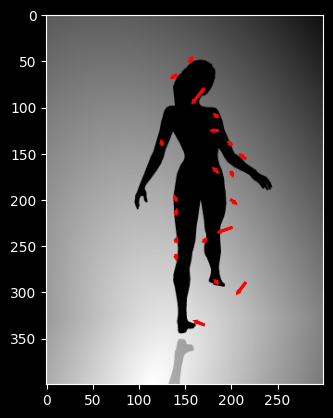

In [10]:
fig, ax = plt.subplots(1, 1)

def showFrame(frame: int):
    ax.clear()
    for row in range(N,sh[0]-N, step):
        for col in range(N,sh[1]-N, step):
            x = solution[frame, row, col]
            dist = np.sqrt(x[0]**2 + x[1]**2)
            if 1 < dist and dist < 10:
                ax.arrow(col, row, x[0]*scale, x[1]*scale, width=0.5, color="red", head_width=1, head_length=1, linewidth=2)
    ax.imshow(data[frame], cmap="gray")


anim = FuncAnimation(fig, showFrame, frames=num_frames-1, interval=1)
anim.save(output_path)